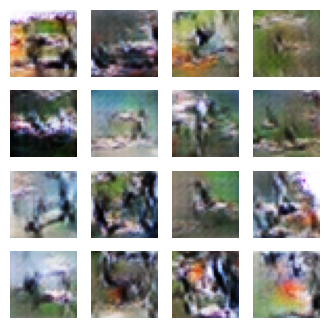

Time for training: 3218 sec


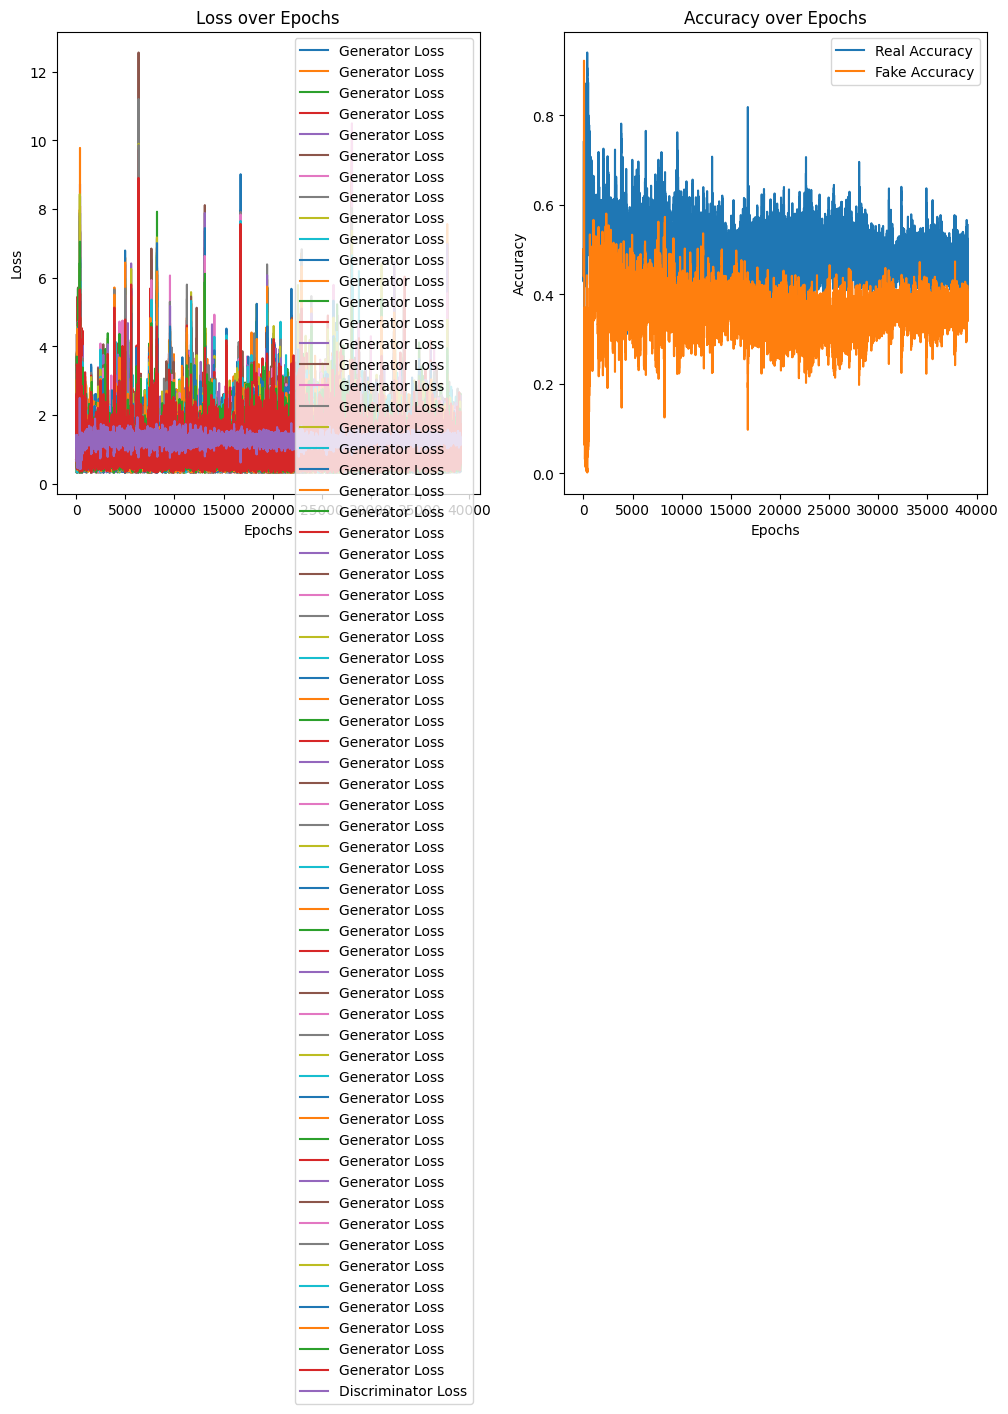

<ipython-input-1-0ee9b9bdc8b6>:203: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)  # 이미지 읽기


-rw-r--r-- 1 root root 2174775 Apr 17 04:09 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


In [ ]:
# 필요한 라이브러리 임포트
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob
from IPython import display

# TensorFlow 및 ImageIO 버전 확인
print("TensorFlow version:", tf.__version__)
print("ImageIO version:", imageio.__version__)

# STEP 2: 작업환경 구성
# 필요한 디렉토리 생성
os.makedirs(os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples'), exist_ok=True)
os.makedirs(os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_checkpoints'), exist_ok=True)
os.makedirs(os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_history'), exist_ok=True)

# STEP 3: 데이터셋 구성
cifar10 = tf.keras.datasets.cifar10  # CIFAR-10 데이터셋 로드
(train_x, _), (test_x, _) = cifar10.load_data()  # 학습 및 테스트 데이터 분리

# 데이터 정규화: [0, 255]를 [-1, 1]로 변환
train_x = (train_x.astype('float32') - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(10000).batch(64)  # 데이터셋을 배치로 나누기

# STEP 4: 생성자 모델 구현 (개선된 버전)
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256 * 8 * 8, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())  # 배치 정규화 추가
    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    # 업샘플링을 통한 이미지 생성
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())  # 배치 정규화 추가

    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())  # 배치 정규화 추가

    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=5, activation='tanh', padding='same'))  # 최종 이미지 생성
    return model

generator = build_generator()  # 생성자 모델 생성

# STEP 5: 판별자 모델 구현 (개선된 버전)
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))  # 드롭아웃 추가

    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))  # 드롭아웃 추가

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 진짜/가짜 판단
    return model

discriminator = build_discriminator()  # 판별자 모델 생성

# 랜덤 이미지로 판별자 결과 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise)
decision = discriminator(generated_image)
print("Discriminator decision on generated image:", decision)

# STEP 6: 손실 함수 및 최적화 함수 구현
def generator_loss(fake_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output) * 0.9, fake_output)  # 레이블 스무딩 적용

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output) * 0.9, real_output)  # 레이블 스무딩 적용
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)  # 총 손실

generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # 생성자 최적화기
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  # 판별자 최적화기

# STEP 7: 훈련 과정 구현
@tf.function
def train_step(images):
    noise = tf.random.normal([64, 100])  # 배치 크기를 64로 설정

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 생성자 훈련

        real_output = discriminator(images, training=True)  # 판별자 훈련 (진짜 이미지)
        fake_output = discriminator(generated_images, training=True)  # 판별자 훈련 (가짜 이미지)

        gen_loss = generator_loss(fake_output)  # 생성자 손실 계산
        disc_loss = discriminator_loss(real_output, fake_output)  # 판별자 손실 계산

    # 기울기 계산 및 업데이트
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # 생성자 가중치 업데이트
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # 판별자 가중치 업데이트

    return gen_loss, disc_loss  # 손실 반환

# STEP 8: 이미지 생성 및 저장 함수
def generate_and_save_images(model, epoch, examples=16):
    noise = tf.random.normal([examples, 100])  # 노이즈 생성
    generated_images = model(noise)  # 이미지 생성

    plt.figure(figsize=(4, 4))  # 이미지 크기 설정
    for i in range(min(examples, generated_images.shape[0])):  # 생성된 이미지 수 제한
        plt.subplot(4, 4, i + 1)  # 4x4 서브플롯 설정
        plt.imshow((generated_images[i] + 1) / 2)  # [-1, 1]을 [0, 1]로 변환
        plt.axis('off')  # 축 숨기기
    plt.savefig(os.path.expanduser(f'~/aiffel/dcgan_newimage/cifar10/generated_samples/epoch_{epoch}.png'))  # 이미지 저장
    plt.show()  # 이미지 출력

# STEP 9: 훈련 기록 시각화 함수
def draw_train_history(history, epoch):
    plt.figure(figsize=(12, 6))  # 그래프 크기 설정

    # 손실 시각화
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label='Generator Loss')  # 생성자 손실 그래프
    plt.plot(history['disc_loss'], label='Discriminator Loss')  # 판별자 손실 그래프
    plt.title('Loss over Epochs')  # 제목
    plt.xlabel('Epochs')  # X축 레이블
    plt.ylabel('Loss')  # Y축 레이블
    plt.legend()  # 범례 추가

    # 정확도 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label='Real Accuracy')  # 진짜 이미지 정확도
    plt.plot(history['fake_accuracy'], label='Fake Accuracy')  # 가짜 이미지 정확도
    plt.title('Accuracy over Epochs')  # 제목
    plt.xlabel('Epochs')  # X축 레이블
    plt.ylabel('Accuracy')  # Y축 레이블
    plt.legend()  # 범례 추가

    plt.savefig(os.path.expanduser(f'~/aiffel/dcgan_newimage/cifar10/training_history/train_history_{epoch}.png'))  # 그래프 저장
    plt.show()  # 그래프 출력

# STEP 10: 체크포인트 설정
checkpoint_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_checkpoints')  # 체크포인트 디렉토리
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")  # 체크포인트 파일 이름
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)  # 체크포인트 설정

# STEP 11: 훈련 과정 실행
def train(dataset, epochs, save_every):
    start = time.time()  # 훈련 시작 시간
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}  # 손실 및 정확도 기록

    for epoch in range(epochs):  # 각 에포크 반복
        epoch_start = time.time()  # 에포크 시작 시간
        for it, image_batch in enumerate(dataset):  # 데이터셋에서 이미지 배치 반복
            gen_loss, disc_loss = train_step(image_batch)  # 훈련 단계 실행
            history['gen_loss'].append(gen_loss.numpy())  # 손실 기록
            history['disc_loss'].append(disc_loss.numpy())  # 손실 기록

            # 정확도 계산
            real_accuracy = tf.reduce_mean(discriminator(image_batch, training=False)).numpy()  # 진짜 이미지 정확도
            fake_accuracy = tf.reduce_mean(discriminator(generator(tf.random.normal([64, 100]), training=False), training=False)).numpy()  # 가짜 이미지 정확도
            history['real_accuracy'].append(real_accuracy)  # 정확도 기록
            history['fake_accuracy'].append(fake_accuracy)  # 정확도 기록

            if it % 50 == 0:  # 50번마다 출력
                display.clear_output(wait=True)  # 출력 지연
                generate_and_save_images(generator, epoch + 1, 16)  # 이미지 생성 및 저장
                print('Epoch {} | Iteration {}'.format(epoch + 1, it + 1))  # 진행 상황 출력
                print('Time for epoch {}: {} sec'.format(epoch + 1, int(time.time() - epoch_start)))  # 에포크 시간 출력

        if (epoch + 1) % save_every == 0:  # 지정된 에포크마다 체크포인트 저장
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)  # 출력 지연
        generate_and_save_images(generator, epochs, 16)  # 마지막 에포크 이미지 생성 및 저장
        print('Time for training: {} sec'.format(int(time.time() - start)))  # 전체 훈련 시간 출력

        draw_train_history(history, epoch)  # 훈련 기록 시각화

save_every = 5  # 체크포인트 저장 간격
EPOCHS = 50  # 총 훈련 에포크 수

# 사용 가능한 GPU 디바이스 확인
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

# 모델 학습
train(train_dataset, EPOCHS, save_every)  # 훈련 시작

# STEP 12: GIF 파일 생성
anim_file = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif')  # GIF 파일 이름

with imageio.get_writer(anim_file, mode='I') as writer:  # GIF 작성을 위한 writer 생성
    filenames = sorted(glob.glob(os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples/epoch_*.png')))  # 생성된 이미지 파일 목록
    for filename in filenames:  # 각 이미지 파일에 대해
        image = imageio.imread(filename)  # 이미지 읽기
        writer.append_data(image)  # GIF에 이미지 추가

# 생성된 GIF 파일 목록 출력
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif  # GIF 파일 확인

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 1, Gen Loss: 1.3910304307937622, Disc Loss: 0.7302604913711548
Epoch: 2, Gen Loss: 0.8107702136039734, Disc Loss: 1.8117369413375854
Epoch: 3, Gen Loss: 3.300405979156494, Disc Loss: 0.09753168374300003
Epoch: 4, Gen Loss: 0.6567155122756958, Disc Loss: 1.4594347476959229
Epoch: 5, Gen Loss: 5.264195919036865, Disc Loss: 0.013796749524772167
Epoch: 6, Gen Loss: 6.379051208496094, Disc Loss: 0.006269155070185661
Epoch: 7, Gen Loss: 5.193813800811768, Disc Loss: 0.01049620471894741
Epoch: 8, Gen Loss: 3.2725789546966553, Disc Loss: 0.06765386462211609
Epoch: 9, Gen Loss: 5.052789688110352, Disc Loss: 0.016866125166416168
Epoch: 10, Gen Loss: 5.31527042388916, Disc Loss: 0.014072151854634285


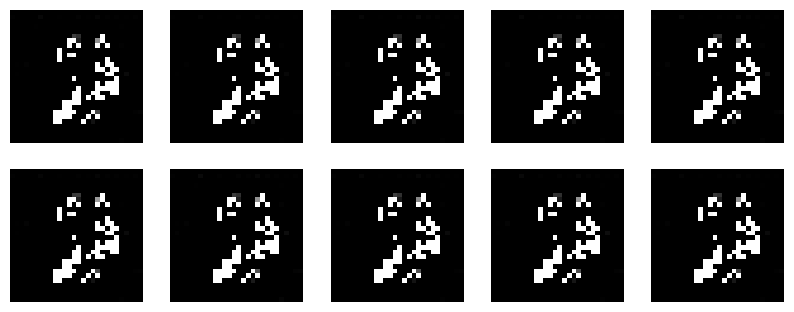

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# 데이터셋 로드 (예: CIFAR-10 대신 다른 데이터셋을 사용할 수 있음)
# 예시로 MNIST 데이터셋을 사용합니다.
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype('float32') / 255.0
train_images = np.expand_dims(train_images, axis=-1)

# 데이터셋 준비
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 모델
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(28 * 28 * 1, activation='sigmoid'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# 판별자 모델
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# 모델 초기화
generator = build_generator()
discriminator = build_discriminator()

# 손실 함수 및 최적화기 설정
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 훈련 과정 구현
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 28, 28, 1])  # 예시로 랜덤 노이즈 생성
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = loss_object(tf.ones_like(fake_output), fake_output)
        disc_loss = loss_object(tf.ones_like(real_output), real_output) + loss_object(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 훈련 함수
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f'Epoch: {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')

EPOCHS = 10  # 에포크 수 설정
train(train_dataset, EPOCHS)

# 생성된 이미지 시각화
def generate_images(model, examples=10):
    noise = tf.random.normal([examples, 28, 28, 1])
    generated_images = model(noise)

    plt.figure(figsize=(10, 10))
    for i in range(examples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

generate_images(generator)

Epoch: 1, Gen Loss: 6.059701919555664, Disc Loss: 0.0052971793338656425
Epoch: 2, Gen Loss: 6.511281967163086, Disc Loss: 0.0027719587087631226
Epoch: 3, Gen Loss: 6.072432041168213, Disc Loss: 0.0031336203683167696
Epoch: 4, Gen Loss: 0.9530802965164185, Disc Loss: 0.948483943939209
Epoch: 5, Gen Loss: 5.632993221282959, Disc Loss: 0.007555726915597916
Epoch: 6, Gen Loss: 5.796738624572754, Disc Loss: 0.006906979251652956
Epoch: 7, Gen Loss: 2.779052495956421, Disc Loss: 0.0809863731265068
Epoch: 8, Gen Loss: 6.02028226852417, Disc Loss: 0.004531449172645807
Epoch: 9, Gen Loss: 5.852533340454102, Disc Loss: 0.006736653856933117
Epoch: 10, Gen Loss: 5.322878837585449, Disc Loss: 0.01600787229835987
Epoch: 11, Gen Loss: 3.95111346244812, Disc Loss: 0.0381329320371151
Epoch: 12, Gen Loss: 1.2722420692443848, Disc Loss: 0.8731802701950073
Epoch: 13, Gen Loss: 4.503269195556641, Disc Loss: 0.02589794062077999
Epoch: 14, Gen Loss: 5.951662540435791, Disc Loss: 0.006932656280696392
Epoch: 15

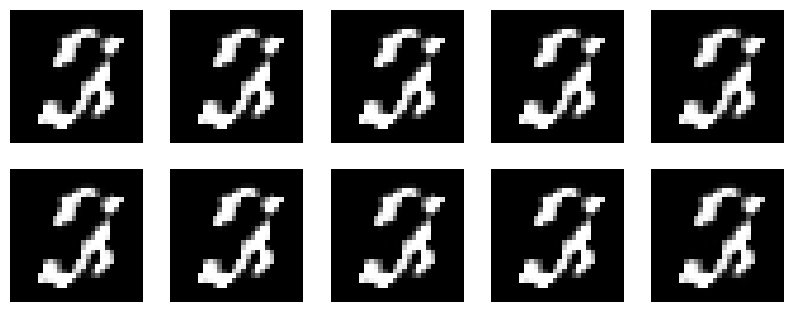

In [ ]:
EPOCHS = 50  # 에포크 수 설정
train(train_dataset, EPOCHS)

# 생성된 이미지 시각화
def generate_images(model, examples=10):
    noise = tf.random.normal([examples, 28, 28, 1])
    generated_images = model(noise)

    plt.figure(figsize=(10, 10))
    for i in range(examples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

generate_images(generator)